##Using pre-trained model Xception to classify savory vs unsavory image

[Xception](https://huggingface.co/docs/timm/en/models/xception)

[Savory Vs Unsavory Data](https://www.kaggle.com/datasets/gpiosenka/good-guysbad-guys-image-data-set?select=test)

Note: I reduced the size of train set randomly to 1000 in each class due to memory issues.

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/good-guysbad-guys-image-data-set

Saving kaggle.json to kaggle.json
 96% 561M/586M [00:06<00:00, 74.7MB/s]
100% 586M/586M [00:06<00:00, 90.1MB/s]


In [3]:
!unzip /content/good-guysbad-guys-image-data-set.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/unsavory/1223.jpg  
  inflating: train/unsavory/1224.jpg  
  inflating: train/unsavory/1225.jpg  
  inflating: train/unsavory/1226.jpg  
  inflating: train/unsavory/1227.jpg  
  inflating: train/unsavory/1228.jpg  
  inflating: train/unsavory/1229.jpg  
  inflating: train/unsavory/1230.jpg  
  inflating: train/unsavory/1231.jpg  
  inflating: train/unsavory/1232.jpg  
  inflating: train/unsavory/1233.jpg  
  inflating: train/unsavory/1234.jpg  
  inflating: train/unsavory/1235.jpg  
  inflating: train/unsavory/1236.jpg  
  inflating: train/unsavory/1237.jpg  
  inflating: train/unsavory/1238.jpg  
  inflating: train/unsavory/1239.jpg  
  inflating: train/unsavory/1240.jpg  
  inflating: train/unsavory/1241.jpg  
  inflating: train/unsavory/1242.jpg  
  inflating: train/unsavory/1243.jpg  
  inflating: train/unsavory/1244.jpg  
  inflating: train/unsavory/1245.jpg  
  inflating: train/unsavory/1246.jpg  
  inflating: 

In [4]:
from pathlib import Path
import random

train_dir = Path("/content/train")

image_dict = {
    'savory': random.sample(list(train_dir.glob('savory/*')), 1000),
    'unsavory': random.sample(list(train_dir.glob('unsavory/*')), 1000)
}

label_dict = {
    'savory': 1,
    'unsavory': 0
}

array([[[255, 253, 238],
        [255, 254, 236],
        [253, 254, 234],
        ...,
        [254, 255, 227],
        [255, 255, 230],
        [255, 255, 231]],

       [[255, 253, 238],
        [255, 254, 236],
        [253, 254, 234],
        ...,
        [254, 255, 227],
        [254, 255, 229],
        [255, 255, 231]],

       [[254, 254, 236],
        [254, 254, 236],
        [253, 254, 234],
        ...,
        [253, 255, 225],
        [254, 255, 227],
        [255, 255, 231]],

       ...,

       [[ 41, 101, 137],
        [ 29,  88, 127],
        [ 46, 103, 148],
        ...,
        [253, 255, 226],
        [252, 254, 225],
        [253, 252, 224]],

       [[ 58, 118, 154],
        [ 20,  79, 118],
        [ 12,  69, 114],
        ...,
        [253, 255, 226],
        [252, 254, 225],
        [253, 252, 224]],

       [[ 66, 126, 162],
        [ 20,  79, 118],
        [  0,  52,  97],
        ...,
        [253, 255, 226],
        [251, 253, 224],
        [252, 252, 222]]], dtype=uint8)
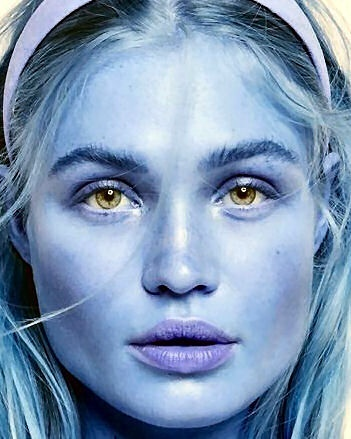

In [6]:
sample_img = cv2.imread(str(image_dict['savory'][0]))
sample_img

In [7]:
X, y = [], []

for names, images in image_dict.items():
  for image in images:
    img = cv2.imread(str(image))
    img = cv2.resize(img,(224,224))
    X.append(img)
    y.append(label_dict[names])

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
#split the data

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [11]:
# importing pre-trained model
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                            include_top=False)

#adding new layers
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

#combinig models
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [12]:
#freezing initial layers
for layer in base_model.layers:
  layer.trainable = False

In [16]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_test_scaled, y_test))

Epoch 1/5
50/50 [==============================] - 13s 223ms/step - loss: 0.4084 - accuracy: 0.8150 - val_loss: 0.5426 - val_accuracy: 0.8025
Epoch 2/5
50/50 [==============================] - 9s 178ms/step - loss: 0.3750 - accuracy: 0.8469 - val_loss: 0.2977 - val_accuracy: 0.8900
Epoch 3/5
50/50 [==============================] - 9s 178ms/step - loss: 0.3555 - accuracy: 0.8644 - val_loss: 0.3123 - val_accuracy: 0.8925
Epoch 4/5
50/50 [==============================] - 9s 175ms/step - loss: 0.2110 - accuracy: 0.9175 - val_loss: 0.2755 - val_accuracy: 0.8975
Epoch 5/5
50/50 [==============================] - 9s 187ms/step - loss: 0.2105 - accuracy: 0.9144 - val_loss: 0.2542 - val_accuracy: 0.9100


In [18]:
# Evaluating the model on external test set


external_dir = Path("/content/test")

external_image_dict = {
    'savory': list(external_dir.glob('savory/*')),
    'unsavory': list(external_dir.glob('unsavory/*'))
}

X_external, y_external = [], []

for names, images in external_image_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        img = cv2.resize(img, (224, 224))
        X_external.append(img)
        y_external.append(label_dict[names])

X_external = np.array(X_external)
y_external = np.array(y_external)

# Scale the data
X_external_scaled = X_external / 255

# Evaluate the model on the external dataset
external_loss, external_accuracy = model.evaluate(X_external_scaled, y_external)

print("External Dataset Loss:", external_loss)
print("External Dataset Accuracy:", external_accuracy)

19/19 [==============================] - 5s 276ms/step - loss: 0.1571 - accuracy: 0.9283
External Dataset Loss: 0.1570812165737152
External Dataset Accuracy: 0.9283333420753479
